In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train=pd.read_csv('/content/drive/Shareddrives/TNT/스터디/2021년 겨울방학/과제/4주차 과제/data/train.csv')
test=pd.read_csv('/content/drive/Shareddrives/TNT/스터디/2021년 겨울방학/과제/4주차 과제/data/test.csv')
submission=pd.read_csv('/content/drive/Shareddrives/TNT/스터디/2021년 겨울방학/과제/4주차 과제/data/submission.csv')


In [ ]:
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [ ]:
test.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
0,0,7,20.7,0.0,1.3,62.0,954.0,0.041,44.0,27.0
1,1,17,30.0,0.0,5.4,33.0,1590.0,0.061,49.0,36.0
2,2,13,19.0,1.0,2.1,95.0,193.0,0.020,36.0,28.0
3,4,6,22.5,0.0,2.5,60.0,1185.0,0.027,52.0,38.0
4,5,22,14.6,1.0,3.4,93.0,218.0,0.041,18.0,15.0


In [ ]:
submission.head()

,id,count
0,0,NaN
1,1,NaN
2,2,NaN
3,4,NaN
4,5,NaN


In [ ]:
print(train.shape)
print(test.shape)
print(submission.shape)

(1459, 11)
(715, 10)
(715, 2)


In [ ]:
train.info()
#이번에 사용하고자 하는 모델은 입력값에 결측값이 있으면 오류를 내게 됨. 
#결측값들을 사전에 채워넣어 줘야 함. 그래서 결측값의 위치를 확인해야 함.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1459 non-null   int64  
 1   hour                    1459 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1450 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1383 non-null   float64
 8   hour_bef_pm10           1369 non-null   float64
 9   hour_bef_pm2.5          1342 non-null   float64
 10  count                   1459 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 125.5 KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715 entries, 0 to 714
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      715 non-null    int64  
 1   hour                    715 non-null    int64  
 2   hour_bef_temperature    714 non-null    float64
 3   hour_bef_precipitation  714 non-null    float64
 4   hour_bef_windspeed      714 non-null    float64
 5   hour_bef_humidity       714 non-null    float64
 6   hour_bef_visibility     714 non-null    float64
 7   hour_bef_ozone          680 non-null    float64
 8   hour_bef_pm10           678 non-null    float64
 9   hour_bef_pm2.5          679 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 56.0 KB


In [ ]:
train.describe() #각각 칼럼별로 기술통계량을 보여줌.

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
count,1459.000000,1459.000000,1457.000000,1457.000000,1450.000000,1457.000000,1457.000000,1383.000000,1369.000000,1342.000000,1459.000000
mean,1105.914325,11.493489,16.717433,0.031572,2.479034,52.231297,1405.216884,0.039149,57.168736,30.327124,108.563400
std,631.338681,6.922790,5.239150,0.174917,1.378265,20.370387,583.131708,0.019509,31.771019,14.713252,82.631733
min,3.000000,0.000000,3.100000,0.000000,0.000000,7.000000,78.000000,0.003000,9.000000,8.000000,1.000000
25%,555.500000,5.500000,12.800000,0.000000,1.400000,36.000000,879.000000,0.025500,36.000000,20.000000,37.000000
50%,1115.000000,11.000000,16.600000,0.000000,2.300000,51.000000,1577.000000,0.039000,51.000000,26.000000,96.000000
75%,1651.000000,17.500000,20.100000,0.000000,3.400000,69.000000,1994.000000,0.052000,69.000000,37.000000,150.000000
max,2179.000000,23.000000,30.000000,1.000000,8.000000,99.000000,2000.000000,0.125000,269.000000,90.000000,431.000000


In [ ]:
test.describe()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
count,715.000000,715.000000,714.000000,714.000000,714.000000,714.000000,714.000000,680.000000,678.000000,679.000000
mean,1056.854545,11.472727,23.263305,0.051821,2.388515,56.668067,1359.494398,0.041196,36.930678,24.939617
std,625.574471,6.928427,4.039645,0.221820,1.171270,19.661880,614.171870,0.020656,12.641503,10.075857
min,0.000000,0.000000,14.600000,0.000000,0.000000,16.000000,126.000000,0.003000,9.000000,7.000000
25%,507.000000,5.500000,20.300000,0.000000,1.500000,42.000000,807.250000,0.027000,28.000000,17.000000
50%,1046.000000,11.000000,22.900000,0.000000,2.300000,55.000000,1489.000000,0.039000,35.000000,24.000000
75%,1616.500000,17.000000,26.375000,0.000000,3.275000,73.750000,2000.000000,0.052250,45.000000,31.000000
max,2177.000000,23.000000,33.800000,1.000000,5.900000,100.000000,2000.000000,0.138000,94.000000,69.000000


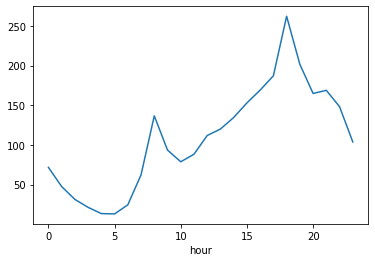

In [ ]:
#시간별로 따릉이 대여량은 어떻게 달라지고 있을까?->시간별로 집단화를 시켜줘야 함.
#hour라는 칼럼별로 groupby를 시킨 후 칼럼별 평균에서 count만 확인해보자
#그래프를 보면 8시에 대여량이 높아졌다가 줄어들고 점점 증가하다가 17시나 18시 정도에 갑자기 급증함.
#그리고 다시 점점 감소 -> 출퇴근, 등하교 시간에 대여량이 확 느는것을 알 수 있음
#데이터를 시각화 해서 기존에 가지고 있는 통념과 아이디어를 확인해 보는 것도 재밌음 ㅎㅎ
#근데 이렇게 선만 있으면 보기 불편! 직관적으로 몇시에 솟았는지 알 수 없음
train.groupby('hour').mean()['count'].plot()

In [ ]:
import matplotlib.pyplot as plt

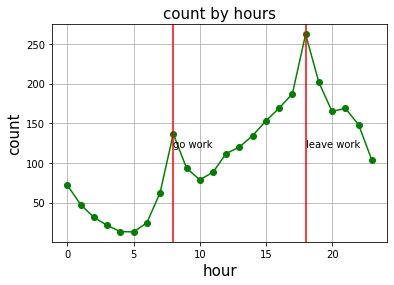

In [ ]:
plt.plot(train.groupby('hour').mean()['count'],'go-') #시간별로 점을 찍고싶다!
#맨 뒤에 'o'->마커o, 'o-'->선과 함께 마커o, 'go-'->green 마커o와 선
plt.grid() #점선 생성
plt.title('count by hours', fontsize=15)
plt.xlabel('hour', fontsize=15)
plt.ylabel('count', fontsize=15)

#자전거 대여량이 급증하는 8시와 18시를 강조하기 위해 보조선을 그어주기
plt.axvline(8,color='r') #color없이 그냥 r 했을 때 오류 뜸!
plt.axvline(18,color='r')

#원하는 텍스트 넣는 코드
plt.text(8, 120, 'go work', fontsize=10)
plt.text(18, 120, 'leave work', fontsize=10)
plt.savefig('picture.png') #->만든 그래프 저장 ㅎㅎ 유용하다 drive의 바깥쪽에 있음!
#그래프를 보면 시간이 증가 할 수록 대여량이 증가하는 것h을 볼 수 있음.
#12개의 변수가 존재하는데 그 변수들마다 하나씩 그래프를 그려보는 것은 비효율!
#그 관계를 한 눈에 볼 수 있는 상관계수를 이용해 수치로 표현. 밑에 나옴~
#분야별로 다르지만 보통 절대값이 0.4 이상이면 상관성이 있다고 본다. 상관계수와 기울기는 다른 것이니 주의
#상관관계와 인과관계도 다른 것. 예를 들면 선글라스 판매량과 아이스크림 판매량의 상관관계가 있을 때
#선글라스 판매량이 증가했기 때문에! 아이스크림 판매량이 늘어났다가 아니라 날씨가 더워짐에 따라 선글라스 판매량이 증가했고 아이스크림 판매량 또한 증가했다 라고 보는 것이 타당

In [ ]:
import seaborn as sns
#좋은 변수들을 걸러내기 위해서 다양한 방법들을 사용하는데 그 중 가장 간단한 것이 상관계수가 높은 것을 채택하는 것임.
#상관계수가 높은 변수들을 채택해서 모델을 생성한다.

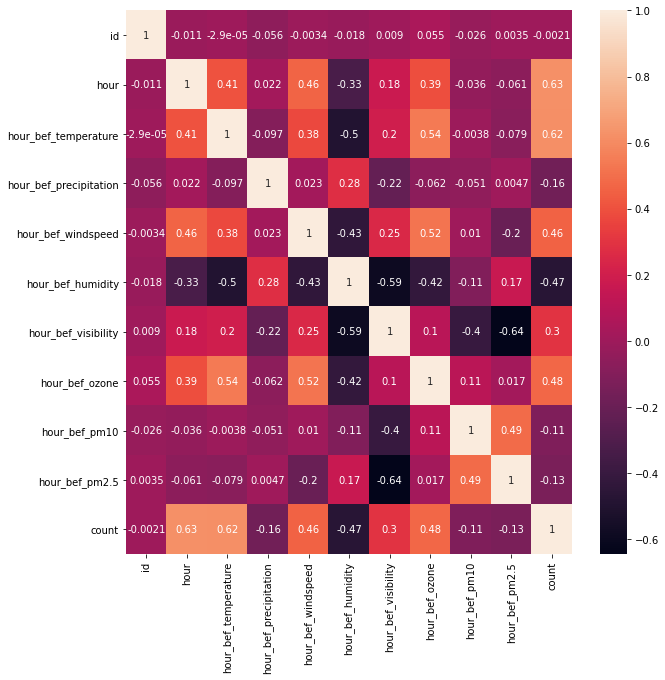

In [ ]:
plt.figure(figsize=(10,10))#하나의 도화지를 그려주겠다. 이거 없이 만들었을 때 heatmap크기가 좀 작아서 추가해준 코드.
sns.heatmap(train.corr(), annot=True) #corr이 상관계수!, annot옵션에 True명시해주면 색깔과 더불어서 수치도 같이 나와서 직관적으로 확인 가능.
#우리는 count를 예측하는 모델을 만들 것이기 때문에 count와 상관계수가 높은 변수를 찾을 것!
#hour, hour_bef_temperature,hour_bef_windspeed, hour_bef_humidity, hour_bef_zone 사용

In [ ]:
train[train['hour_bef_temperature'].isna()] #한시간 전 온도의 결측치의 위치.(인덱싱 해서)
#자정과 18시에 결측치가 있음. 그런데 낮과 밤의 온도차가 크기 때문에 타이타닉 때 했던 것 처럼 전체 평균값을 넣어 버리면 해당 데이터의 특징을 잘 나타내주지 못하게 됨

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
934,1420,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


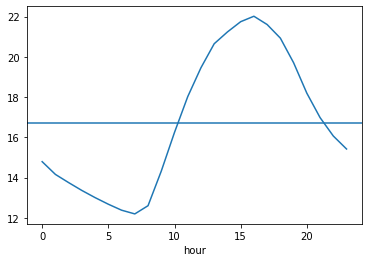

In [ ]:
train.groupby('hour').mean()['hour_bef_temperature'].plot()#시간별 온도 평균
plt.axhline(train.groupby('hour').mean()['hour_bef_temperature'].mean())#전체평균을 시각화
#axvline은 vertical의 v , axhline은 horizon으로 수평선 생성


In [ ]:
train.groupby('hour').mean()['hour_bef_temperature']
#각 시간의 평균으로 결측치를 대체해서 경향성을 더 잘 반영하도록 해보겠음.

hour
0     14.788136
1     14.155738
2     13.747541
3     13.357377
4     13.001639
5     12.673770
6     12.377049
7     12.191803
8     12.600000
9     14.318033
10    16.242623
11    18.019672
12    19.457377
13    20.648333
14    21.234426
15    21.744262
16    22.015000
17    21.603333
18    20.926667
19    19.704918
20    18.191803
21    16.978333
22    16.063934
23    15.418033
Name: hour_bef_temperature, dtype: float64

In [ ]:
train['hour_bef_temperature'].fillna({934:14.788136,1035:20.926667 },inplace=True)
#null값을 교체해주자!딕셔너리 형태로 넣어주기. 934번째 행을 0시 평균값으로 대체, 1035째 행을 18시 평균값을 대체.
#inplace=True안해주면 그냥 보여주기만 함. 이거 해줘야지 저장까지 이뤄짐

In [ ]:
train[train['hour_bef_windspeed'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
18,33,13,22.600000,0.0,NaN,41.0,987.0,0.046,64.0,39.0,208.0
244,381,1,14.100000,0.0,NaN,55.0,1992.0,NaN,NaN,NaN,38.0
260,404,3,14.000000,0.0,NaN,50.0,2000.0,0.049,35.0,22.0,17.0
376,570,0,14.300000,0.0,NaN,49.0,2000.0,0.044,37.0,20.0,58.0
780,1196,20,16.500000,0.0,NaN,31.0,2000.0,0.058,39.0,18.0,181.0
934,1420,0,14.788136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,20.926667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1138,1717,12,21.400000,0.0,NaN,44.0,1375.0,0.044,61.0,37.0,116.0
1229,1855,2,14.000000,0.0,NaN,52.0,2000.0,0.044,37.0,20.0,20.0


In [ ]:
train[train['hour_bef_windspeed'].isna()].index
#밑에 교체하는 코드 쓸 때 인덱스에 맡는 windspped 평균값을 채워넣어줘야 하기 때문에
#index 뽑아보기

Int64Index([18, 244, 260, 376, 780, 934, 1035, 1138, 1229], dtype='int64')

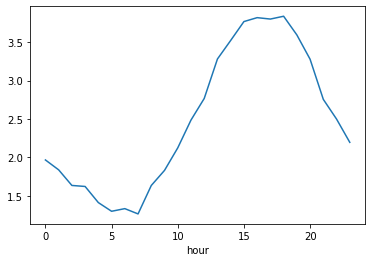

In [ ]:
train.groupby('hour').mean()['hour_bef_windspeed'].plot()
#얘도 시간별로 다른 경향을 보임. 온도처럼 해줘야겠다! 시간에 따른 경향성을 반영

In [ ]:
train.groupby('hour').mean()['hour_bef_windspeed']

hour
0     1.965517
1     1.836667
2     1.633333
3     1.620000
4     1.409836
5     1.296721
6     1.331148
7     1.262295
8     1.632787
9     1.829508
10    2.122951
11    2.485246
12    2.766667
13    3.281356
14    3.522951
15    3.768852
16    3.820000
17    3.801667
18    3.838333
19    3.595082
20    3.278333
21    2.755000
22    2.498361
23    2.195082
Name: hour_bef_windspeed, dtype: float64

In [ ]:
train['hour_bef_windspeed'].fillna({18:3.281356, 244:1.866667, 260:1.620000, 376:1.965517, 780:3.278333, 934:1.965517, 1035:3.838333, 1138:2.766667, 1229: 1.633333 },inplace=True)

In [ ]:
train.loc[[18,244,1138], :] #잘 대체되었는지 확인

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
18,33,13,22.6,0.0,3.281356,41.0,987.0,0.046,64.0,39.0,208.0
244,381,1,14.1,0.0,1.866667,55.0,1992.0,NaN,NaN,NaN,38.0
1138,1717,12,21.4,0.0,2.766667,44.0,1375.0,0.044,61.0,37.0,116.0


In [ ]:
train[train['hour_bef_humidity'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
934,1420,0,14.788136,NaN,1.965517,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,20.926667,NaN,3.838333,NaN,NaN,NaN,NaN,NaN,1.0


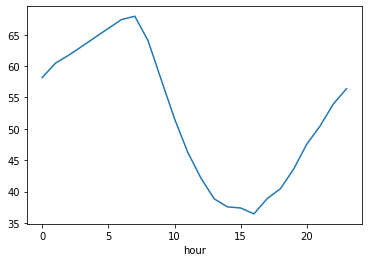

In [ ]:
train.groupby('hour').mean()['hour_bef_humidity'].plot()

In [ ]:
train.groupby('hour').mean()['hour_bef_humidity']

hour
0     58.169492
1     60.459016
2     61.721311
3     63.131148
4     64.573770
5     66.000000
6     67.409836
7     67.934426
8     64.049180
9     57.803279
10    51.622951
11    46.262295
12    42.147541
13    38.850000
14    37.573770
15    37.393443
16    36.450000
17    38.883333
18    40.450000
19    43.573770
20    47.573770
21    50.450000
22    53.950820
23    56.393443
Name: hour_bef_humidity, dtype: float64

In [ ]:
train['hour_bef_humidity'].fillna({934:58.169492, 1035:40.450000},inplace=True)

In [ ]:
train.loc[[934,1035], :]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
934,1420,0,14.788136,NaN,1.965517,58.169492,NaN,NaN,NaN,NaN,39.0
1035,1553,18,20.926667,NaN,3.838333,40.450000,NaN,NaN,NaN,NaN,1.0


In [ ]:
train[train['hour_bef_ozone'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
14,28,1,20.0,0.0,1.8,58.0,2000.0,NaN,NaN,NaN,74.0
44,76,17,21.7,0.0,3.0,35.0,2000.0,NaN,32.0,19.0,213.0
46,78,1,12.2,0.0,3.0,49.0,1071.0,NaN,NaN,NaN,36.0
84,130,1,9.4,0.0,2.5,65.0,1907.0,NaN,NaN,NaN,39.0
122,181,16,26.2,0.0,4.3,31.0,1718.0,NaN,47.0,23.0,136.0
...,...,...,...,...,...,...,...,...,...,...,...
1283,1941,1,16.6,0.0,2.1,35.0,2000.0,NaN,NaN,NaN,62.0
1322,1994,1,15.1,0.0,1.3,35.0,2000.0,NaN,NaN,NaN,40.0
1329,2005,1,17.7,0.0,1.0,43.0,1338.0,NaN,NaN,NaN,69.0
1361,2047,1,12.6,0.0,2.4,48.0,1805.0,NaN,NaN,NaN,43.0


In [ ]:
train[train['hour_bef_ozone'].isna()].index #아 결측치 너무 많다!!

Int64Index([  14,   44,   46,   84,  122,  140,  142,  147,  158,  176,  222,
             236,  244,  265,  289,  317,  324,  331,  356,  422,  429,  451,
             463,  466,  472,  479,  507,  532,  537,  554,  576,  579,  589,
             595,  623,  624,  631,  645,  649,  660,  686,  698,  708,  728,
             745,  763,  778,  796,  811,  861,  868,  876,  897,  934,  957,
             970, 1024, 1035, 1070, 1100, 1120, 1142, 1154, 1156, 1165, 1168,
            1186, 1211, 1221, 1273, 1278, 1283, 1322, 1329, 1361, 1391],
           dtype='int64')

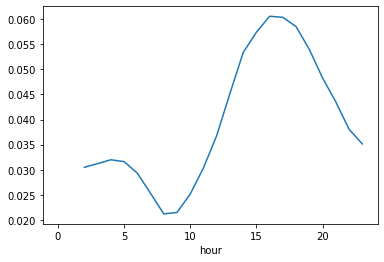

In [ ]:
train.groupby('hour').mean()['hour_bef_ozone'].plot() #근데 또 시간에 영향 많이 받으니까 하나하나 찾아서 바꿔줘야겠네 ..

In [ ]:
print(train.groupby('hour').mean()['hour_bef_ozone'])
hour1 = (0.033763+0.030492)/2
print("1시의 nan 값은 0시와 2시 사이 값",hour1,"로 대체")
#1시가 다 nan값인가본데?
#0시와 2시 사이 값으로 바꿔주겠음!
#이제 hour bef ozone 중에서 hour가 1인 인덱스들을 알아보고 싶은데 ..! 어떻게 하지 조건문? groupby?



hour
0     0.033763
1          NaN
2     0.030492
3     0.031213
4     0.031984
5     0.031623
6     0.029317
7     0.025300
8     0.021197
9     0.021492
10    0.025167
11    0.030367
12    0.036817
13    0.045203
14    0.053344
15    0.057400
16    0.060579
17    0.060362
18    0.058508
19    0.053967
20    0.048279
21    0.043517
22    0.038066
23    0.035148
Name: hour_bef_ozone, dtype: float64
1시의 nan 값은 0시와 2시 사이 값 0.0321275 로 대체


In [ ]:
ahour = train['hour'] == 1

# 조건를 충족하는 데이터를 필터링하여 새로운 변수에 저장합니다.
one = train[ahour]

# 결과를 출력합니다.
print(one)
print(one.index)

train.loc[train.hour == 1, 'hour_bef_ozone'] = 0.0321275
print(train[train['hour_bef_ozone'].isna()].index)
#오 됐다!!! hour 값 1인 것만 먼저 바꿔주기 성공

        id  hour  hour_bef_temperature  ...  hour_bef_pm10  hour_bef_pm2.5  count
14      28     1                  20.0  ...            NaN             NaN   74.0
46      78     1                  12.2  ...            NaN             NaN   36.0
84     130     1                   9.4  ...            NaN             NaN   39.0
142    208     1                  18.8  ...            NaN             NaN   62.0
147    220     1                  18.4  ...            NaN             NaN   63.0
...    ...   ...                   ...  ...            ...             ...    ...
1283  1941     1                  16.6  ...            NaN             NaN   62.0
1322  1994     1                  15.1  ...            NaN             NaN   40.0
1329  2005     1                  17.7  ...            NaN             NaN   69.0
1361  2047     1                  12.6  ...            NaN             NaN   43.0
1391  2086     1                  11.5  ...            NaN             NaN   42.0

[61 rows x 11 c

In [ ]:
train[train['hour_bef_ozone'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
44,76,17,21.700000,0.0,3.000000,35.000000,2000.0,NaN,32.0,19.0,213.0
122,181,16,26.200000,0.0,4.300000,31.000000,1718.0,NaN,47.0,23.0,136.0
140,206,10,18.200000,0.0,2.400000,60.000000,527.0,NaN,NaN,NaN,66.0
422,654,18,20.300000,0.0,4.100000,24.000000,2000.0,NaN,57.0,27.0,320.0
451,695,17,20.100000,0.0,4.500000,25.000000,2000.0,NaN,58.0,29.0,236.0
532,823,12,22.300000,0.0,2.800000,51.000000,575.0,NaN,NaN,NaN,121.0
537,829,7,18.700000,0.0,2.000000,69.000000,915.0,NaN,NaN,NaN,127.0
595,912,11,20.300000,0.0,2.600000,56.000000,576.0,NaN,NaN,NaN,95.0
631,967,15,26.300000,0.0,3.600000,30.000000,1805.0,NaN,50.0,22.0,131.0
645,987,6,18.700000,0.0,1.000000,72.000000,634.0,NaN,NaN,NaN,53.0


In [ ]:
train['hour_bef_ozone'].fillna({44:0.060362, 122:0.060579,140:0.025167, 422:0.058508, 451:0.060362, 532:0.036817,537:0.025300, 595:0.030367,631:0.057400,
                                645:0.029317, 868:0.060579, 897:0.045203, 934:0.033763, 1035:0.058508, 1211:0.060579},inplace=True)
#귀찮은거 끝! 근데 이거 맨 첨에 상관관계 구할 때 ozone에 널값 엄청 많았는데 유의한 상관관계 맞나 ..? 

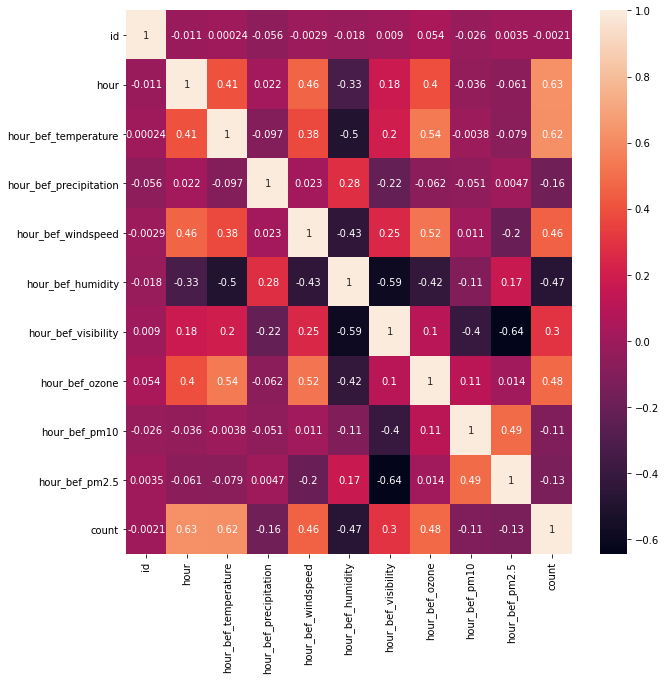

In [ ]:
#그래서 다시 그려봤는데 맞네!
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), annot=True)

In [ ]:
train.isna().sum()#우리가 사용할 hour,hour_bef_temperature,hour_bef_windspeed, hour_bef_humidity, hour_bef_ozone에 null값이 없는 것 확인
#이제 test에도 똑같이 해준다 ... ㅠ

id                          0
hour                        0
hour_bef_temperature        0
hour_bef_precipitation      2
hour_bef_windspeed          0
hour_bef_humidity           0
hour_bef_visibility         2
hour_bef_ozone              0
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

In [ ]:
print(test[test['hour_bef_ozone'].isna()].index)
ahour = test['hour'] == 1

# 조건를 충족하는 데이터를 필터링하여 새로운 변수에 저장합니다.
one = test[ahour]

# 결과를 출력합니다.
print(one.index)

Int64Index([ 32,  40,  47,  86,  92, 102, 114, 126, 129, 209, 212, 223, 272,
            307, 353, 355, 360, 386, 393, 418, 419, 458, 471, 492, 502, 523,
            620, 626, 637, 642, 653, 658, 694, 710, 711],
           dtype='int64')
Int64Index([ 32,  40,  47,  86,  92, 102, 114, 126, 129, 209, 223, 272, 307,
            353, 355, 360, 393, 418, 419, 458, 471, 492, 502, 523, 620, 626,
            642, 694, 710, 711],
           dtype='int64')


In [ ]:
print(test.groupby('hour').mean()['hour_bef_ozone'])
hour1 = (0.029933+0.029400)/2
print("1시의 nan 값은 0시와 2시 사이 값",hour1,"로 대체")
#1시가 다 nan값인가본데?
#0시와 2시 사이 값으로 바꿔주겠음!

hour
0     0.029933
1          NaN
2     0.029400
3     0.031267
4     0.032833
5     0.032690
6     0.031633
7     0.028100
8     0.025800
9     0.026900
10    0.029367
11    0.034067
12    0.040000
13    0.049276
14    0.058893
15    0.065138
16    0.067759
17    0.066759
18    0.061655
19    0.054207
20    0.048133
21    0.041000
22    0.034767
23    0.032733
Name: hour_bef_ozone, dtype: float64
1시의 nan 값은 0시와 2시 사이 값 0.0296665 로 대체


In [ ]:
test.loc[test.hour == 1, 'hour_bef_ozone'] = 0.0296665

print(test[test['hour_bef_ozone'].isna()])

       id  hour  ...  hour_bef_pm10  hour_bef_pm2.5
212   614    15  ...           32.0            21.0
386  1122    14  ...           29.0            13.0
637  1898    13  ...           21.0            15.0
653  1943    19  ...            NaN             NaN
658  1959    14  ...           25.0            18.0

[5 rows x 10 columns]


In [ ]:
test['hour_bef_ozone'].fillna({212:0.065138, 386:0.058893, 637:0.049276, 653:0.054207, 658:0.058893},inplace=True)

In [ ]:
test[test['hour_bef_temperature'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
653,1943,19,NaN,NaN,NaN,NaN,NaN,0.054207,NaN,NaN


In [ ]:
test.groupby('hour').mean()['hour_bef_temperature']

hour
0     21.386667
1     20.986667
2     20.600000
3     20.203333
4     19.853333
5     19.634483
6     19.243333
7     19.190000
8     19.846667
9     21.266667
10    22.683333
11    24.110000
12    25.430000
13    26.630000
14    27.473333
15    28.040000
16    28.255172
17    27.848276
18    27.010345
19    26.110345
20    24.803333
21    23.696552
22    22.523333
23    21.926667
Name: hour_bef_temperature, dtype: float64

In [ ]:
test['hour_bef_temperature'].fillna(26.110345, inplace=True)
#['hour_bef_temperature']로 칼럼명을 명시해주지 않고 test.fillna(~~)이것만 해주면
#이 행의 모든값이 대체 됨.

In [ ]:
test[test['hour_bef_windspeed'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
653,1943,19,26.110345,NaN,NaN,NaN,NaN,0.054207,NaN,NaN


In [ ]:
test.groupby('hour').mean()['hour_bef_windspeed']

hour
0     1.986667
1     1.840000
2     1.823333
3     1.636667
4     1.543333
5     1.589655
6     1.396667
7     1.453333
8     1.446667
9     1.646667
10    1.920000
11    2.186667
12    2.636667
13    2.836667
14    2.903333
15    3.140000
16    3.406897
17    3.558621
18    3.503448
19    3.541379
20    3.406667
21    3.041379
22    2.686667
23    2.336667
Name: hour_bef_windspeed, dtype: float64

In [ ]:
test['hour_bef_windspeed'].fillna(3.541379, inplace=True)

In [ ]:
test[test['hour_bef_humidity'].isna()]

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5
653,1943,19,26.110345,NaN,3.541379,NaN,NaN,0.054207,NaN,NaN


In [ ]:
test.groupby('hour').mean()['hour_bef_humidity']

hour
0     63.200000
1     65.000000
2     67.266667
3     68.700000
4     69.600000
5     70.034483
6     72.333333
7     71.900000
8     67.700000
9     62.366667
10    57.100000
11    52.366667
12    47.033333
13    42.766667
14    40.566667
15    38.900000
16    40.000000
17    42.689655
18    45.793103
19    47.689655
20    50.566667
21    53.517241
22    59.700000
23    61.900000
Name: hour_bef_humidity, dtype: float64

In [ ]:
test['hour_bef_humidity'].fillna(47.689655, inplace=True)

In [ ]:
test.isna().sum()

id                         0
hour                       0
hour_bef_temperature       0
hour_bef_precipitation     1
hour_bef_windspeed         0
hour_bef_humidity          0
hour_bef_visibility        1
hour_bef_ozone             0
hour_bef_pm10             37
hour_bef_pm2.5            36
dtype: int64

## 모델링

In [ ]:
features=['hour', 'hour_bef_temperature', 'hour_bef_windspeed','hour_bef_humidity','hour_bef_ozone']#우리가 사용할 변수들
X_train=train[features] 
y_train=train['count']
X_test=test[features]

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(1459, 5)
(1459,)
(715, 5)


In [ ]:
params = {
    'n_estimators':(100,200),
    'max_depth':(12,20,28),
    'min_samples_leaf':(5,10,18),
    'min_samples_split':(8,20)
}
rf_hit = RandomForestRegressor(random_state=0, n_jobs=1)
grid_cv=GridSearchCV(rf_hit, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:', grid_cv.best_params_)
print('최적 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 200}
최적 예측 정확도: 0.7203


In [ ]:
rf_hit = RandomForestRegressor(random_state=0,max_depth=20, min_samples_leaf=5, min_samples_split=8, n_estimators=200)
rf_hit.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=20, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
y_pred = rf_hit.predict(X_test)


In [ ]:
submission['count']=y_pred
submission.to_csv('model.csv', index=False)